In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [47]:
# load the dataset
data_path = "../data/interim/location_data.csv"

df_reader = pd.read_csv(data_path,chunksize=100000)
df_reader

In [48]:
# do sampling

all_samples = []

df_reader = pd.read_csv(data_path,chunksize=100000)

for df in df_reader:
    all_samples.append(df.sample(500))

sample_df = pd.concat(all_samples,axis =0)

In [49]:
sample_df.shape

(166500, 2)

Text(0, 0.5, 'Latitude')

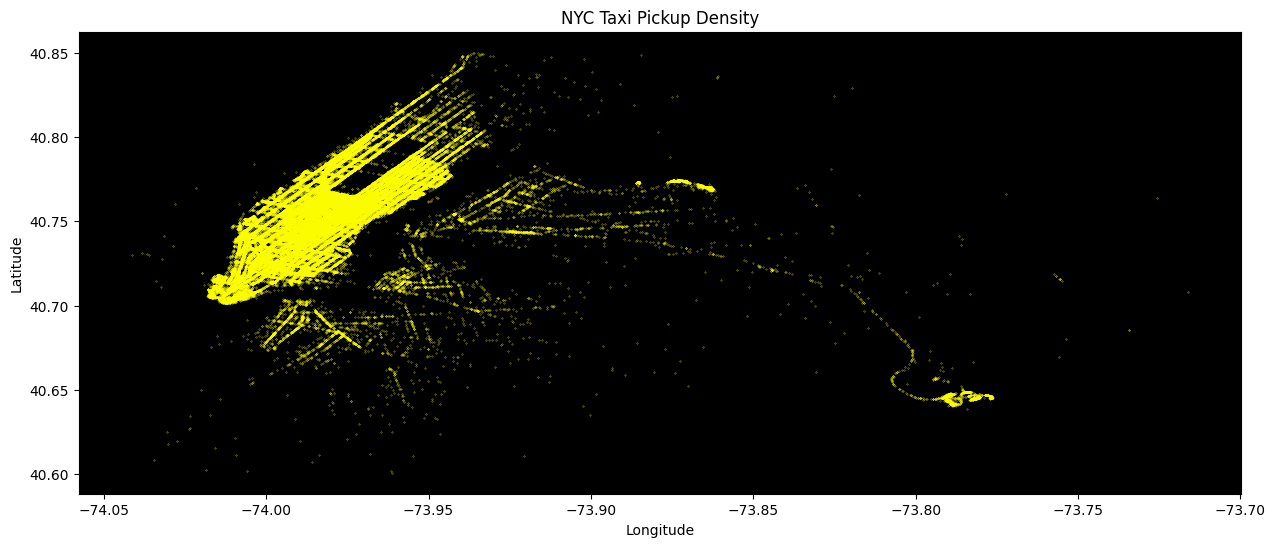

In [50]:
# plot the dataset on scatterplot

fig,ax = plt.subplots(nrows=1,ncols=1,sharey=True,figsize = (15,6))

ax.set_facecolor('k')
ax.scatter(sample_df['pickup_longitude'],sample_df['pickup_latitude'],s=0.05,color='yellow')
ax.set_title('NYC Taxi Pickup Density')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

In [51]:
from sklearn import set_config

set_config(transform_output='pandas')

In [52]:
sample_df

,pickup_latitude,pickup_longitude
49233,40.774529,-73.948112
28900,40.755604,-73.967796
31789,40.779419,-73.955711
92710,40.768578,-73.989388
88805,40.773251,-73.982567
...,...,...
33216510,40.750172,-73.979393
33221324,40.740353,-74.005653
33231665,40.740772,-74.005203
33221859,40.744495,-73.988907


In [53]:
# scale the input columns

from sklearn.preprocessing import StandardScaler

scale_samples = StandardScaler()

scaled_samples_df = scale_samples.fit_transform(sample_df)

In [54]:
scaled_samples_df

,pickup_latitude,pickup_longitude
49233,0.860808,0.701970
28900,0.168325,0.168845
31789,1.039757,0.496159
92710,0.643055,-0.415939
88805,0.814047,-0.231205
...,...,...
33216510,-0.030445,-0.145243
33221324,-0.389738,-0.856490
33231665,-0.374383,-0.844298
33221859,-0.238148,-0.402920


Text(0, 0.5, 'Latitude')

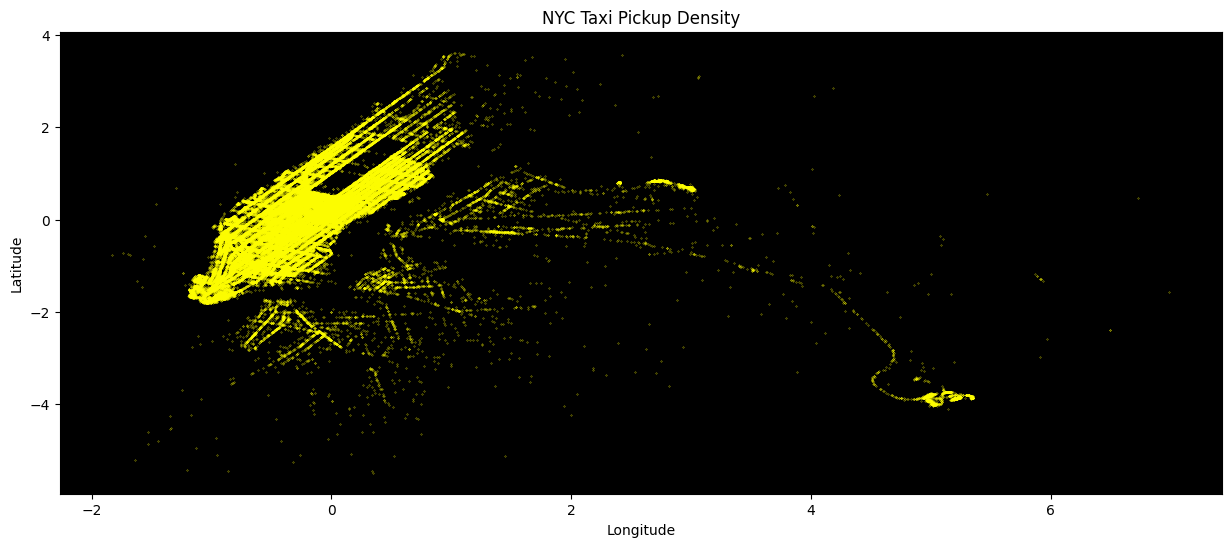

In [55]:
# is there  a diff in pattern ? No which shows no changes in distribution which is good

# plot the dataset on scatterplot

fig,ax = plt.subplots(nrows=1,ncols=1,sharey=True,figsize = (15,6))

ax.set_facecolor('k')
ax.scatter(scaled_samples_df['pickup_longitude'],scaled_samples_df['pickup_latitude'],s=0.05,color='yellow')
ax.set_title('NYC Taxi Pickup Density')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

In [56]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler

In [57]:
df_reader = pd.read_csv(data_path,chunksize=100000)

In [58]:
# train the standerd scaler
scaler =StandardScaler()

for chunk in df_reader:
    scaler.partial_fit(chunk)

In [59]:
scaler

,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True


In [60]:
# get the scaler std and mean

print("The mean values are ", scaler.mean_)
print("The sigma values(std) are ", scaler.scale_)

The mean values are  [ 40.75107121 -73.9740618 ]
The sigma values(std) are  [0.02722268 0.03675237]


In [61]:
# calculate havesine distance

def haversine_distance(lat1:float,lon1:float,lat2:float,lon2:float):
    """
    Calculate haversine distances between two points given their latitude and
    longitude coordinates
    """

    lon1,lat1,lon2,lat2 = map(np.radians,[lon1,lat1,lon2,lat2])
    dlon = lon2-lon1
    dlat = lat2-lat1

    a = np.sin(
        dlat / 2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0)**2
    
    c = 2 * np.arcsin(np.sqrt(a))

    earth_radius = 3958.8
    distance = earth_radius * c
    return distance



In [62]:
def select_optimum_k(k_values):
    for k in k_values:
        df_reader = pd.read_csv(data_path, chunksize=100000)
        mini_batch = MiniBatchKMeans(n_clusters=k, n_init=10, random_state=42)
        
        for chunk in df_reader:
            # scale the chunk
            scaled_chunk = scaler.transform(chunk)
            # train the model
            mini_batch.partial_fit(scaled_chunk)
            
        # centroid values
        centroids = scaler.inverse_transform(mini_batch.cluster_centers_)
        # calculate distances
        all_distances = []
        for i in centroids:
            distances = []
            for j in centroids:
                distance = haversine_distance(i[0], i[1], j[0], j[1])
                distances.append(distance)
            all_distances.append(distances)
        all_distances = np.array(all_distances)
        # sort array
        sorted_distances = np.sort(all_distances, axis=-1)
        # nearby regions
        region_count = 8
        # selected distances
        selected_distances = sorted_distances[:, 1:region_count+1]
        # average distances
        avg_distances = selected_distances.mean(axis=1)
        # count averages that fit criteria
        counter = ((avg_distances >= 1.0) & (avg_distances <= 1.5)).sum()
        percentage = ((avg_distances >= 1.0) & (avg_distances <= 1.5)).mean()
        print(f"For {k} clusters, the number of nearby regions that fits criteria are {counter} and is {percentage * 100:.1f}% regions of total")
           
        

In [63]:
# check
possible_k_values = np.arange(10,100,10)

possible_k_values

array([10, 20, 30, 40, 50, 60, 70, 80, 90])

In [64]:
# select the optimum value for k
select_optimum_k(k_values=possible_k_values)


For 10 clusters, the number of nearby regions that fits criteria are 0 and is 0.0% regions of total
For 20 clusters, the number of nearby regions that fits criteria are 6 and is 30.0% regions of total
For 30 clusters, the number of nearby regions that fits criteria are 9 and is 30.0% regions of total
For 40 clusters, the number of nearby regions that fits criteria are 8 and is 20.0% regions of total
For 50 clusters, the number of nearby regions that fits criteria are 7 and is 14.0% regions of total
For 60 clusters, the number of nearby regions that fits criteria are 10 and is 16.7% regions of total
For 70 clusters, the number of nearby regions that fits criteria are 13 and is 18.6% regions of total
For 80 clusters, the number of nearby regions that fits criteria are 14 and is 17.5% regions of total
For 90 clusters, the number of nearby regions that fits criteria are 17 and is 18.9% regions of total


# clustering

In [65]:
df_reader = pd.read_csv(data_path, chunksize=100000)

In [66]:
# train the model

mini_batch = MiniBatchKMeans(n_clusters=30, n_init=10, random_state=42)

for chunk in df_reader:
    # scale the chunk
    scaled_chunk = scaler.transform(chunk)
    # train the model
    mini_batch.partial_fit(scaled_chunk)

In [67]:
mini_batch

,"n_clusters n_clusters: int, default=8The number of clusters to form as well as the number ofcentroids to generate.",30
,"init init: {'k-means++', 'random'}, callable or array-like of shape (n_clusters, n_features), default='k-means++'Method for initialization:'k-means++' : selects initial cluster centroids using sampling based onan empirical probability distribution of the points' contribution to theoverall inertia. This technique speeds up convergence. The algorithmimplemented is ""greedy k-means++"". It differs from the vanilla k-means++by making several trials at each sampling step and choosing the best centroidamong them.'random': choose `n_clusters` observations (rows) at random from datafor the initial centroids.If an array is passed, it should be of shape (n_clusters, n_features)and gives the initial centers.If a callable is passed, it should take arguments X, n_clusters and arandom state and return an initialization.For an evaluation of the impact of initialization, see the example:ref:`sphx_glr_auto_examples_cluster_plot_kmeans_stability_low_dim_dense.py`.",'k-means++'
,"max_iter max_iter: int, default=100Maximum number of iterations over the complete dataset beforestopping independently of any early stopping criterion heuristics.",100
,"batch_size batch_size: int, default=1024Size of the mini batches.For faster computations, you can set `batch_size > 256 * number_of_cores`to enable :ref:`parallelism `on all cores... versionchanged:: 1.0 `batch_size` default changed from 100 to 1024.",1024
,"verbose verbose: int, default=0Verbosity mode.",0
,"compute_labels compute_labels: bool, default=TrueCompute label assignment and inertia for the complete datasetonce the minibatch optimization has converged in fit.",True
,"random_state random_state: int, RandomState instance or None, default=NoneDetermines random number generation for centroid initialization andrandom reassignment. Use an int to make the randomness deterministic.See :term:`Glossary `.",42
,"tol tol: float, default=0.0Control early stopping based on the relative center changes asmeasured by a smoothed, variance-normalized of the mean centersquared position changes. This early stopping heuristics iscloser to the one used for the batch variant of the algorithmsbut induces a slight computational and memory overhead over theinertia heuristic.To disable convergence detection based on normalized centerchange, set tol to 0.0 (default).",0.0
,"max_no_improvement max_no_improvement: int, default=10Control early stopping based on the consecutive number of minibatches that does not yield an improvement on the smoothed inertia.To disable convergence detection based on inertia, setmax_no_improvement to None.",10
,"init_size init_size: int, default=NoneNumber of samples to randomly sample for speeding up theinitialization (sometimes at the expense of accuracy): theonly algorithm is initialized by running a batch KMeans on arandom subset of the data. This needs to be larger than n_clusters.If `None`, the heuristic is `init_size = 3 * batch_size` if`3 * batch_size < n_clusters`, else `init_size = 3 * n_clusters`.",None
,"n_init n_init: 'auto' or int, default=""auto""Number of random initializations that are tried.In contrast to KMeans, the algorithm is only run once, using the best ofthe `n_init` initializations as measured by inertia. Several runs arerecommended for sparse high-dimensional problems (see:ref:`kmeans_sparse_high_dim`).When `n_init='auto'`, the number of runs depends on the value of init:3 if using `init='random'` or `init` is a callable;1 if using `init='k-means++'` or `init` is an array-like... versionadded:: 1.2 Added 'auto' option for `n_init`... versionchanged:: 1.4 Default value for `n_init` changed to `'auto'` in version.",10


In [68]:
# centroids of the model

mini_batch.cluster_centers_

array([[ 1.94149572,  0.6614905 ],
       [-0.13980742, -0.07596928],
       [-1.99721801,  1.44528196],
       [-3.83635934,  5.15118517],
       [-1.16343866, -0.81227839],
       [ 0.42137614, -0.13488625],
       [ 0.72209007,  2.8610836 ],
       [-0.52924948, -0.39015448],
       [ 1.07003845,  0.56520318],
       [-2.24451716, -0.3303071 ],
       [-1.00166487, -0.4036074 ],
       [ 1.16185672, -0.10175947],
       [-0.08902033, -0.55920139],
       [ 0.31820801,  1.59046972],
       [-0.04552948, -0.25372558],
       [ 0.20846098, -0.35389222],
       [-1.31780812,  0.52314378],
       [ 2.79102906,  0.81932304],
       [ 0.28712745,  0.12935608],
       [ 0.73099844, -0.27639436],
       [-1.53772972, -1.0082658 ],
       [ 0.67692302,  0.39844824],
       [-0.76412025, -0.74701446],
       [ 1.62394033,  0.1378545 ],
       [-3.07963657, -0.43385234],
       [ 0.3506753 , -0.54018812],
       [-0.57100818, -0.17842182],
       [-0.38830582, -0.76072368],
       [-2.66479788,

In [69]:
scaler.inverse_transform(mini_batch.cluster_centers_)

array([[ 40.80392392, -73.94975046],
       [ 40.74726528, -73.97685385],
       [ 40.69670159, -73.92094427],
       [ 40.64663525, -73.78474354],
       [ 40.7193993 , -74.00391496],
       [ 40.7625422 , -73.97901919],
       [ 40.77072843, -73.8689102 ],
       [ 40.73666362, -73.9884009 ],
       [ 40.78020052, -73.95328925],
       [ 40.68996945, -73.98620137],
       [ 40.72380321, -73.98889533],
       [ 40.78270006, -73.9778017 ],
       [ 40.74864784, -73.99461378],
       [ 40.75973368, -73.91560827],
       [ 40.74983178, -73.98338682],
       [ 40.75674608, -73.98706818],
       [ 40.71519695, -73.95483503],
       [ 40.82705049, -73.94394974],
       [ 40.75888759, -73.96930766],
       [ 40.77097094, -73.98421995],
       [ 40.70921009, -74.01111796],
       [ 40.76949887, -73.95941789],
       [ 40.73026981, -74.00151635],
       [ 40.79527921, -73.96899532],
       [ 40.66723527, -73.9900069 ],
       [ 40.76061753, -73.993915  ],
       [ 40.73552684, -73.98061923],
 

In [70]:
# perform prediction and assign clustets

sample_predictions = mini_batch.predict(scaled_samples_df)
sample_predictions.shape

(166500,)

In [71]:
np.unique(sample_predictions)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], dtype=int32)

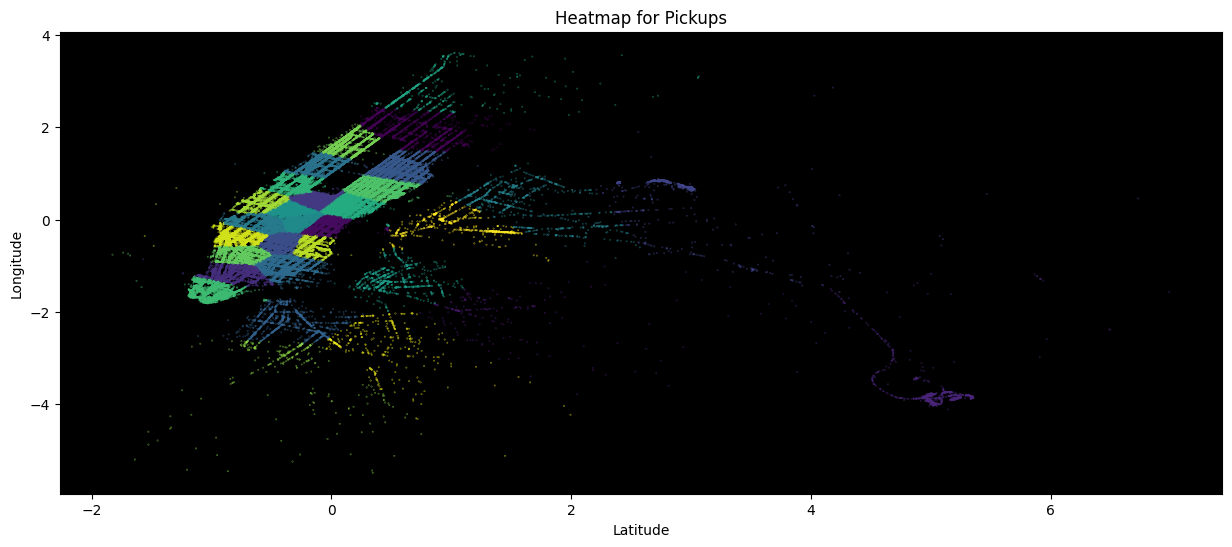

In [73]:
# plot the dataset on a scatterplot

fig,ax = plt.subplots(nrows=1,ncols=1,sharey=True,
                     figsize=(15,6))

ax.set_facecolor('k')
ax.scatter(scaled_samples_df['pickup_longitude'],scaled_samples_df['pickup_latitude'],
           s=0.05,c=sample_predictions)
ax.set_title('Heatmap for Pickups')
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')

plt.show()